In [1]:
!pip install wordcloud

In [2]:
!pip install -U spacy

Requirement already up-to-date: spacy in c:\users\bhagabat\anaconda31\lib\site-packages (3.1.1)


In [71]:
import re
import string
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.metrics import accuracy_score,plot_confusion_matrix,classification_report,confusion_matrix
from wordcloud import WordCloud
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

In [72]:
df=pd.read_csv("fake_job_postings.csv")

In [73]:
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [74]:
df.shape


(17880, 18)

In [75]:
df.isnull().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [76]:
columns=["job_id","telecommuting","has_questions","has_company_logo","salary_range","employment_type"]
for colu in columns:
    del df[colu]

In [77]:
df.head()

,title,location,department,company_profile,description,requirements,benefits,required_experience,required_education,industry,function,fraudulent
0,Marketing Intern,"US, NY, New York",Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,Internship,NaN,NaN,Marketing,0
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,NaN,NaN,NaN,NaN,0
3,Account Executive - Washington DC,"US, DC, Washington",Sales,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,Bill Review Manager,"US, FL, Fort Worth",NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [78]:
df.fillna('',inplace=True)

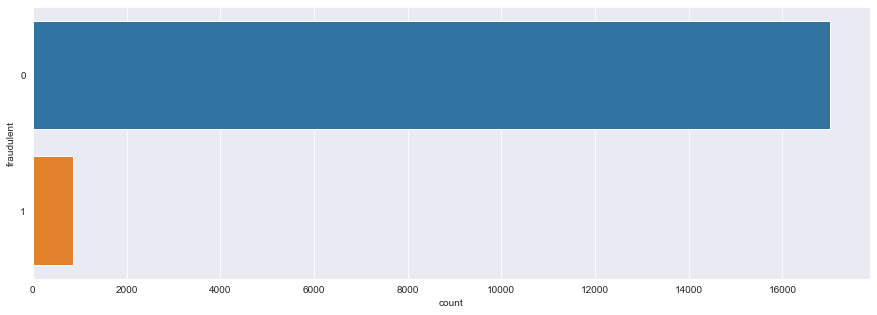

In [79]:
import seaborn as sns
plt.figure(figsize=(15,5))
sns.countplot(y='fraudulent',data=df)
plt.show()

In [80]:
df.groupby('fraudulent')['fraudulent'].count()

fraudulent
0    17014
1      866
Name: fraudulent, dtype: int64

In [81]:
exp = dict(df.required_experience.value_counts())
del exp['']

In [82]:
exp

{'Mid-Senior level': 3809,
 'Entry level': 2697,
 'Associate': 2297,
 'Not Applicable': 1116,
 'Director': 389,
 'Internship': 381,
 'Executive': 141}

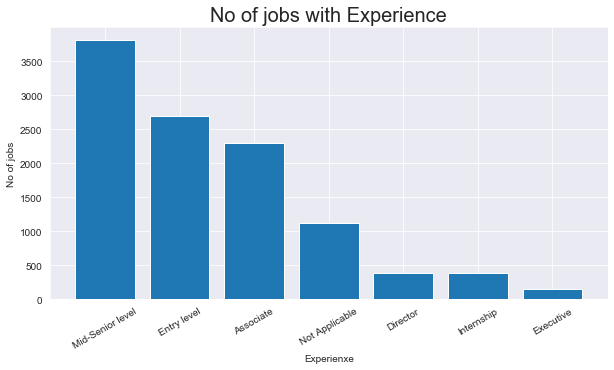

In [83]:
plt.figure(figsize=(10,5))
sns.set_style("darkgrid")
plt.bar(exp.keys(),exp.values())
plt.title("No of jobs with Experience",size=20)
plt.xlabel("Experienxe",size=10)
plt.ylabel("No of jobs",size=10)
plt.xticks(rotation=30)
plt.show()

In [84]:
def split(location):
    l=location.split(',')
    return l[0]
df['country'] = df.location.apply(split)

In [85]:
df.head()

,title,location,department,company_profile,description,requirements,benefits,required_experience,required_education,industry,function,fraudulent,country
0,Marketing Intern,"US, NY, New York",Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,Internship,,,Marketing,0,US
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,Not Applicable,,Marketing and Advertising,Customer Service,0,NZ
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,,,,,0,US
3,Account Executive - Washington DC,"US, DC, Washington",Sales,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,US
4,Bill Review Manager,"US, FL, Fort Worth",,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,US


In [86]:
countr= dict(df.country.value_counts()[:14])
del countr['']
countr

{'US': 10656,
 'GB': 2384,
 'GR': 940,
 'CA': 457,
 'DE': 383,
 'NZ': 333,
 'IN': 276,
 'AU': 214,
 'PH': 132,
 'NL': 127,
 'BE': 117,
 'IE': 114,
 'SG': 80}

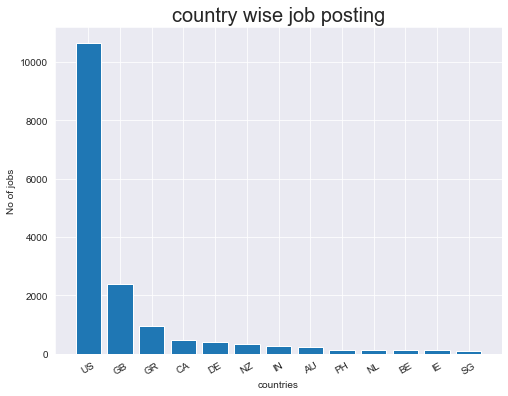

In [87]:
plt.figure(figsize =(8,6))
plt.title("country wise job posting",size =20)
plt.bar(countr.keys(),countr.values())
plt.xlabel("countries",size=10)
plt.ylabel("No of jobs",size=10)
plt.xticks(rotation=30)
plt.show()

In [88]:
edu =  dict(df.required_education.value_counts()[:7])
del edu['']
edu

{"Bachelor's Degree": 5145,
 'High School or equivalent': 2080,
 'Unspecified': 1397,
 "Master's Degree": 416,
 'Associate Degree': 274,
 'Certification': 170}

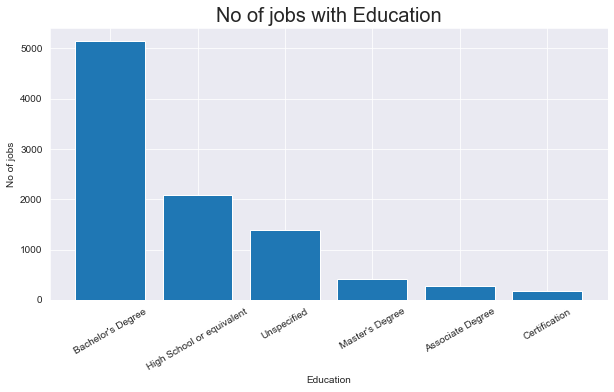

In [89]:
plt.figure(figsize=(10,5))
sns.set_style("darkgrid")
plt.bar(edu.keys(),edu.values())
plt.title("No of jobs with Education",size=20)
plt.xlabel("Education",size=10)
plt.ylabel("No of jobs",size=10)
plt.xticks(rotation=30)
plt.show()

In [90]:
print(df[df.fraudulent == 0].title.value_counts()[:10])

English Teacher Abroad                                311
Customer Service Associate                            146
Graduates: English Teacher Abroad (Conversational)    144
English Teacher Abroad                                 95
Software Engineer                                      86
English Teacher Abroad (Conversational)                83
Customer Service Associate - Part Time                 76
Account Manager                                        73
Web Developer                                          66
Project Manager                                        62
Name: title, dtype: int64


In [91]:
df.head()

,title,location,department,company_profile,description,requirements,benefits,required_experience,required_education,industry,function,fraudulent,country
0,Marketing Intern,"US, NY, New York",Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,Internship,,,Marketing,0,US
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,Not Applicable,,Marketing and Advertising,Customer Service,0,NZ
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,,,,,0,US
3,Account Executive - Washington DC,"US, DC, Washington",Sales,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,US
4,Bill Review Manager,"US, FL, Fort Worth",,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,US


In [92]:
df['text']= df['title']+' '+df['company_profile']+' '+df['requirements']+' '+df['benefits']
del df['title']
del df['location']
del df['department']
del df['company_profile']
del df['description']
del df['requirements']
del df['benefits']
del df['required_experience']
del df['required_education']
del df['industry']
del df['function']
del df['country']

In [93]:
df.head()

,fraudulent,text
0,0,"Marketing Intern We're Food52, and we've creat..."
1,0,Customer Service - Cloud Video Production 90 S...
2,0,Commissioning Machinery Assistant (CMA) Valor ...
3,0,Account Executive - Washington DC Our passion ...
4,0,Bill Review Manager SpotSource Solutions LLC i...


In [94]:
df.tail()

,fraudulent,text
17875,0,Account Director - Distribution Vend is looki...
17876,0,Payroll Accountant WebLinc is the e-commerce p...
17877,0,Project Cost Control Staff Engineer - Cost Con...
17878,0,Graphic Designer 1. Must be fluent in the lat...
17879,0,Web Application Developers Vend is looking for...


In [95]:
fraudjobs_text= df[df.fraudulent==1].text
realjobs_text = df[df.fraudulent==0].text

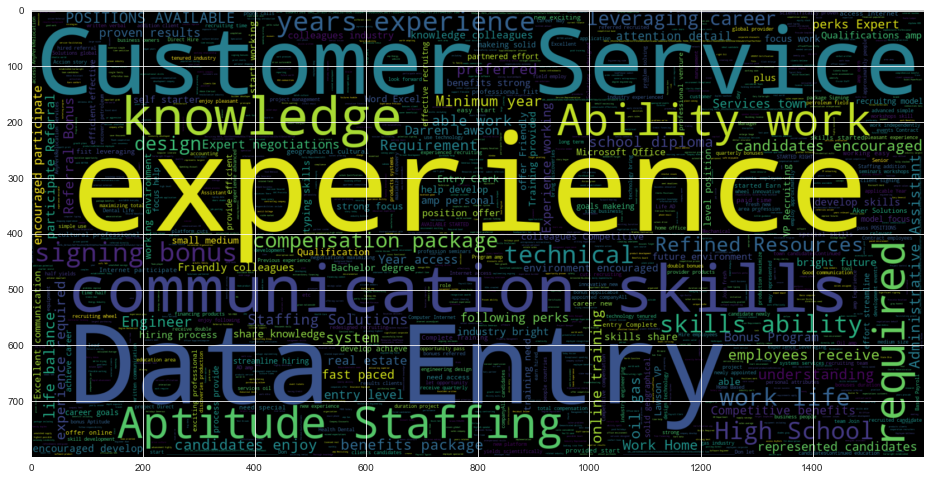

In [98]:
from wordcloud import WordCloud 
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
plt.figure(figsize=(16,14))
wc = WordCloud(min_font_size = 3,max_words = 3000,width =1600,height =800,stopwords = STOPWORDS).generate(str(" ".join(fraudjobs_text)))
plt.imshow(wc,interpolation ="bilinear")

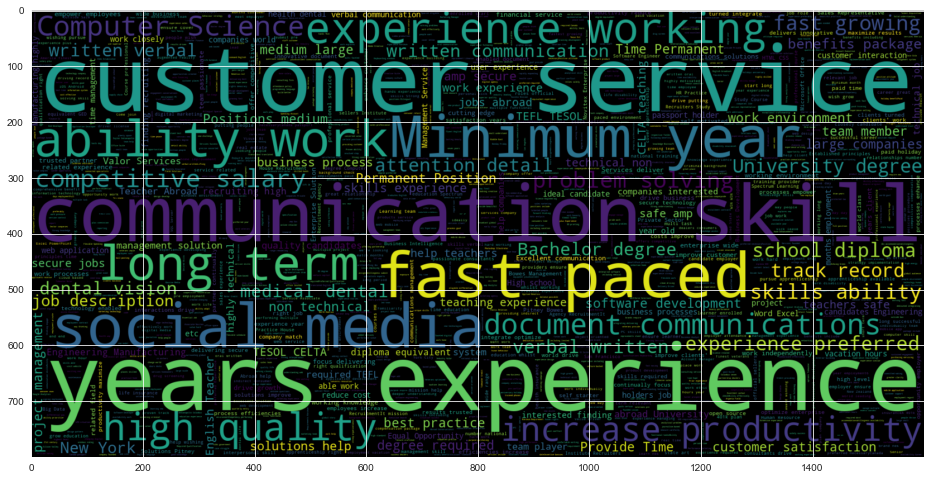

In [99]:
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
plt.figure(figsize=(16,14))
wc = WordCloud(min_font_size = 3,max_words = 3000,width =1600,height =800,stopwords = STOPWORDS).generate(str(" ".join(realjobs_text)))
plt.imshow(wc,interpolation ="bilinear")

In [100]:
!pip install spacy && python -m spacy download en

[!] As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the full
pipeline package name 'en_core_web_sm' instead.
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


2021-08-12 11:30:09.172338: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2021-08-12 11:30:09.172365: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
C:\Users\Bhagabat\Anaconda31\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Bhagabat\Anaconda31\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Bhagabat\Anaconda31\lib\site-packages

In [106]:
punctuations = string.punctuation
nlp = spacy.load("en_core_web_sm")
stop_words = spacy.lang.en.stop_words.STOP_WORDS

parser = English()

def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [word.lema_.lower().strip() if word.lemma_!="-PRON-"else word.lower_ for word in mytokens]
    mytockens = [word for word in mytokens if word not in stop_words and word not in punctuations]
    return mytokens
class predictors(TransformerMixin):
    def transform(self,x,**transform_params):
        return [clean_text(text) for text in x]
    def fit(self,X,y=None,**fit_params):
        return self
    def getparams(self,deep =True):
        return {}
def clean_text(text):
    return text.strip().lower()

In [107]:
df['text'] = df['text'].apply(clean_text)

In [110]:
cv = TfidfVectorizer(max_features = 100)
x= cv.fit_transform(df['text'])
df1 = pd.DataFrame(x.toarray(),columns = cv.get_feature_names())
df.drop(["text"], axis = 1,inplace=True)
main_df = pd.concat([df1,df],axis =1)

In [111]:
main_df.head()

,ability,about,all,also,amp,an,and,are,as,at,...,who,will,with,work,working,world,years,you,your,fraudulent
0,0.000000,0.061673,0.000000,0.063927,0.000000,0.000000,0.705096,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.186812,0.000000,0.100825,0.000000,0.000000,0.000000,0.000000,0
1,0.032046,0.110029,0.030559,0.038017,0.032565,0.048672,0.467698,0.023039,0.050008,0.055130,...,0.000000,0.158725,0.185159,0.045938,0.149900,0.071961,0.000000,0.294697,0.208892,0
2,0.000000,0.000000,0.184549,0.000000,0.049167,0.036742,0.340889,0.139136,0.000000,0.000000,...,0.000000,0.047928,0.335462,0.069357,0.000000,0.000000,0.000000,0.121345,0.090109,0
3,0.047515,0.000000,0.000000,0.000000,0.000000,0.000000,0.669551,0.000000,0.000000,0.040871,...,0.053791,0.000000,0.109815,0.068113,0.000000,0.106697,0.039928,0.000000,0.044247,0
4,0.000000,0.000000,0.060999,0.000000,0.065004,0.048577,0.450693,0.091976,0.049911,0.000000,...,0.000000,0.000000,0.036960,0.045849,0.059843,0.000000,0.053754,0.053477,0.178702,0


In [112]:
Y = main_df.iloc[:,-1]
X= main_df.iloc[:,:-1]

X_train,X_test,Y_train,Y_test = train_test_split(X,Y, test_size = 0.3)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(12516, 100)
(5364, 100)
(12516,)
(5364,)


In [118]:
from sklearn.ensemble import RandomForestClassifier
rfc= RandomForestClassifier(n_jobs=3,oob_score = True,n_estimators = 100,criterion = "entropy")
model = rfc.fit(X_train,Y_train)

In [119]:
print(X_test)

        ability     about       all      also       amp        an       and  \
3443   0.246022  0.000000  0.000000  0.000000  0.250009  0.000000  0.247628   
8693   0.061123  0.000000  0.116573  0.000000  0.124227  0.092835  0.492178   
6941   0.000000  0.000000  0.000000  0.000000  0.272547  0.000000  0.000000   
9316   0.000000  0.000000  0.000000  0.117747  0.000000  0.075374  0.249755   
2839   0.058260  0.000000  0.055556  0.000000  0.000000  0.044243  0.469124   
...         ...       ...       ...       ...       ...       ...       ...   
3208   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.307744   
8953   0.000000  0.000000  0.000000  0.000000  0.099924  0.149346  0.519604   
2802   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.144591   
7229   0.106481  0.000000  0.101539  0.000000  0.000000  0.080863  0.696644   
11751  0.000000  0.225993  0.000000  0.000000  0.000000  0.099969  0.331249   

            are        as        at  ...      what 

In [122]:
pred = rfc.predict(X_test)
score = accuracy_score(Y_test,pred)
score

0.970730797912006